# Pipeline for running inference and classifying pushup reps

In [1]:
import sys
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import svm
from sklearn import linear_model
from sklearn import tree

sys.path.append('../data')
sys.path.append('..')
sys.path.append('../inference')
sys.path.append('../feedback')

import testing_utils as tu
from ai_trainer import Personal_Trainer

%matplotlib inline

# Step 1: Instantiate our personal trainer and load preprocessed data

In [2]:
pt = Personal_Trainer({'pushup':'NeckY'})
exercise = 'pushup'

#=====[ Rehydrate dataset for training ]=====
pt.load_reps(exercise, os.path.join('../data/data_sets','pushupDataSet109.p'))

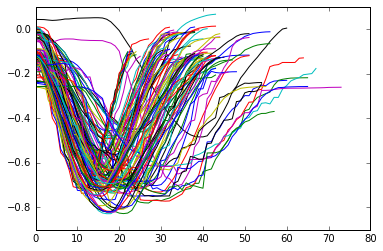

In [3]:
plt.clf()
for pushup in pt.get_reps(exercise):
    plt.plot(-pushup['NeckY'])

# Step 2: Forward Search

In [4]:
def forward_search(num_features, X, Y, file_names, clf_class, **kwargs):
    
    #=====[ Keeps track of best global accuracy and fscore ]======
    best_accuracy = 0
    best_fscore = 0 
    
    #=====[ Builds new feature vector and returns indices of best features to use ]=====
    X_new = X[:,0:0]
    indices = []
        
    for feature in range(num_features):

        #=====[ Used to make sure we have not found a maximum in our accuracy/fscore ]======
        feature_added = False
        
        #=====[ Loops through every feature in X to find the next best feature ]=====
        for index in range(X.shape[1]):
                
            X_temp = np.concatenate([X_new,X[:,index:(index+1)]],axis=1)
            
            fscore, accuracy = tu.rnd_prediction(X_temp,Y,file_names,clf_class,**kwargs)

            #=====[ Checks mean square error between accuracy and f_score ]=====
            if ((1-accuracy)**2 + (1-fscore)**2) < ((1-best_accuracy)**2 + (1-best_fscore)**2):
                best_accuracy = accuracy
                best_fscore = fscore
                best_index = index
                feature_added = True

        if feature_added:
            indices.append(best_index)
            X_new = np.concatenate([X_new,X[:,best_index:(best_index+1)]],axis=1)
        else:
            break
    
    #=====[ Print stats and return indices of top features ]=====
    print "Best accuracy:", best_accuracy
    print "Best f-score:", best_fscore
    return indices           

# Step 3: Classification

## Best performing classifiers for 5 squat components

In [5]:
X3, Y3, file_names = pt.extract_pu_features(multiples=[float(x)/20 for x in range(1,20)])
X30 = np.concatenate([X3[x] for x in X3], axis=1)

#=====[ Best Classifier for Head-Back Alignment ]=====
print 'Logistic Regression with L1'
print "Fscore: %f, Accuracy: %f" % tu.rnd_prediction(X30, Y3['head_back'], file_names, linear_model.LogisticRegression, penalty='l1', C=5)

indices = forward_search(10,X30, Y3['head_back'], file_names, linear_model.LogisticRegression, penalty='l1', C=5)
print indices


Logistic Regression with L1
Fscore: 0.391753, Accuracy: 0.454545
Best accuracy: 0.666666666667
Best f-score: 0.653846153846
[42]


In [7]:
#=====[Best Classifier for Knees Straight ]=====
print 'Logistic Regression with L1'

print '\n\nLogistic Regression with L1\n\n'
print "Fscore: %f, Accuracy: %f" % tu.rnd_prediction(X30, Y3['knees_straight'], file_names, linear_model.LogisticRegression, penalty='l1', C=8)
indices = forward_search(10, X30, Y3['knees_straight'], file_names, linear_model.LogisticRegression, penalty='l1', C=8)
print indices

Logistic Regression with L1


Logistic Regression with L1


Fscore: 0.580645, Accuracy: 0.881818
Best accuracy: 0.927272727273
Best f-score: 0.714285714286
[26, 6]


In [10]:
#=====[ Best Classifier for Elbow Angle ]=====
print 'Logistic Regression with L1'

print '\n\nLogistic Regression with L1\n\n'
print "Fscore: %f, Accuracy: %f" % tu.rnd_prediction(X3['elbow_angle'], Y3['elbow_angle'], file_names, linear_model.LogisticRegression, penalty='l1',C=1)
indices = forward_search(10, X30, Y3['elbow_angle'], file_names, linear_model.LogisticRegression, penalty='l1',C=1)
print indices

Logistic Regression with L1


Logistic Regression with L1


Fscore: 0.846154, Accuracy: 0.963636
Best accuracy: 0.981818181818
Best f-score: 0.923076923077
[9, 40, 3, 7]


In [11]:
#=====[ Aggregate feature indices and store ]=====
feature_indices = {'head_back':[26], 'knees_straight':[26, 6], 'elbow_angle':[9, 40, 3, 7]}
pickle.dump(feature_indices,open('pushup_feature_indicies.p','wb'))



#Step 4: Plot Accuracy and F-Score vs. Number of States


In [23]:
#=====[ Plot accuracy and F-score for elbow_angle averaged over 20 iteration ]======
f_score = []
f_score_t = []
accuracy = []
accuracy_t = []

num_iters = 20

#=====[ Using full feature set and y labels for elbow_angle ]=====
for _ in range(0,num_iters):
    f, ft, a, at = tu.rnd_prediction_increase_training(X30, Y3['elbow_angle'], file_names, linear_model.LogisticRegression, num_slices=10, penalty='l1',C=1,)
    f_score.append(f)
    f_score_t.append(ft)
    accuracy.append(a)
    accuracy_t.append(at)

In [24]:
#=====[ Average each of num_iter runs ]=====
f = [np.average(l) for l in zip(*list(f_score))]
ft = [np.average(l) for l in zip(*list(f_score_t))]
a = [np.average(l) for l in zip(*list(accuracy))]
at = [np.average(l) for l in zip(*list(accuracy_t))]

[0, 100, 0, 1.0]

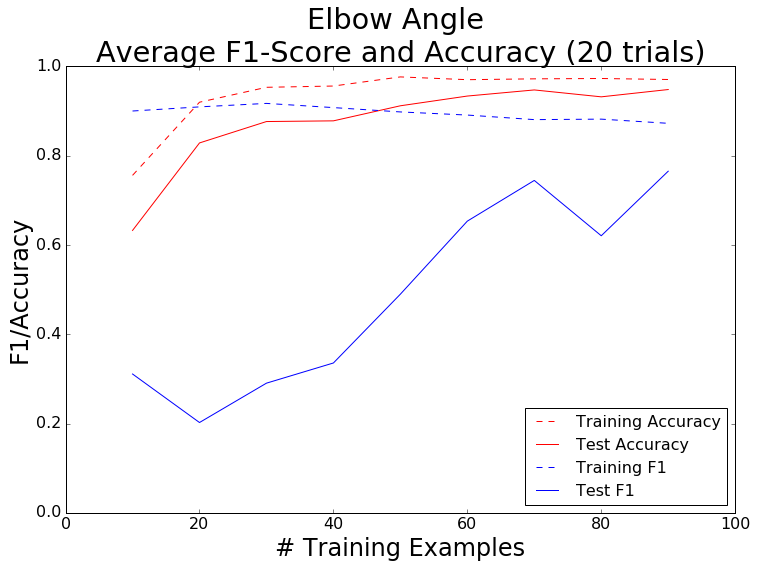

In [25]:
num_training_examples = [x*10 for x in range(1,10)]

#=====[ Plot test and training f_scores and accuracies ]====
plt.plot(num_training_examples, at, color='r', linestyle='--', label='Training Accuracy')
plt.plot(num_training_examples, a, color='r', label='Test Accuracy')
plt.plot(num_training_examples, ft, color='b', linestyle='--', label='Training F1')
plt.plot(num_training_examples, f, color='b', label='Test F1')

#=====[ Add appropriate plot decorations - preparing for saving ]=====
plt.legend(loc='lower right', prop={'size':16})
plt.title('Elbow Angle \nAverage F1-Score and Accuracy (20 trials)')
plt.xlabel('# Training Examples')
plt.ylabel('F1/Accuracy')
figure = plt.gcf() # get current figure
figure.set_size_inches(12, 8)
plt.rcParams.update({'font.size': 24})
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.axis([0, 100, 0, 1.0])
